### Import and Functions

In [2]:
import numpy as np
from scipy.sparse.linalg import expm
from scipy.constants import hbar, pi
import matplotlib.pyplot as plt

def generate_hams(n_min, n_max, phi_L, omega_R_plus, omega_R_minus, delta_L, delta_D, delta_R):
    """Generates Hamiltonians necessary for simulating alternating pulse sequences.
    NOTE: Hamiltonians exclude factor of hbar since it is divided away when calculating time evolution.

    Args:
        n_min (int): Lowest momentum state (i.e. bottom of the ladder) in units of hbar*k_eff.
        n_max (int): Highest momentum state (i.e top of the ladder) in units of hbar*k_eff. Basis then runs from n_min to n_max in integer steps.
        phi_L (float): Laser phase, specifically the phase difference between both Raman components.
        omega_R_plus (float): Rabi frequency of upwards pulse in 2pi*Hz.
        omega_R_minus (float): Rabi frequency of downwards pulse in 2pi*Hz.
        delta_L (float): Two-photon detuning of laser in 2pi*Hz.
        delta_D (float): Doppler shift detuning in 2pi*Hz.
        delta_R (float): Recoil shift detuning in 2pi*Hz.
        

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: A tuple containing:
            - H0 (np.ndarray): A 2D array of shape (n_max-n_min, n_max-n_min) representing the drift Hamiltonian.
            - Hplus (np.ndarray): A 2D array of shape (n_max-n_min, n_max-n_min) representing the Hamiltonian for an upwards Raman pulse.
            - Hminus (np.ndarray): A 2D array of shape (n_max-n_min, n_max-n_min) representing the Hamiltonian for a downwards Raman pulse.
            - basis (np.ndarray): A 1D array containing the basis of momentum states in units of hbar*k_eff.
    """
    n_tot = n_max - n_min + 1
    basis = np.arange(n_min, n_max + 1)
    
    ### Generate H0 ###
    # Diagonal matrix
    # Ground states are even momenta and excited states are odd
    H0 = np.zeros((n_tot, n_tot), dtype=np.complex128)
    for i in range(n_tot):
        n = basis[i]
        if n % 2 == 0:
            H0[i,i] = n*(delta_D + n*delta_R)
        else:
            H0[i,i] = n*(delta_D + n*delta_R) - delta_L
    
    ### Generate H+ ###
    # Care is taken to not go out of range of array, 
    # for Hplus if ground (even mom) then n < n_max,
    # if excited (odd mom) then n > n_min
    Hplus = np.zeros((n_tot, n_tot), dtype=np.complex128)
    for row in range(n_tot):
        n = basis[row]
        if (n % 2 == 0) and (n < n_max):
            Hplus[row, row + 1] = (omega_R_plus/2)*np.exp(-1j*phi_L)
        elif (n % 2 != 0) and (n > n_min):
            Hplus[row, row - 1] = (omega_R_plus/2)*np.exp(1j*phi_L)
            
    ### Generate H- ###
    # Care is taken to not go out of range of array, 
    # for Hplus if ground (even mom) then n > n_min,
    # if excited (odd mom) then n < n_max
    Hminus = np.zeros((n_tot, n_tot), dtype=np.complex128)
    for row in range(n_tot):
        n = basis[row]
        if (n % 2 == 0) and (n > n_min):
            Hminus[row, row - 1] = (omega_R_minus/2)*np.exp(-1j*phi_L)
        elif (n % 2 != 0) and (n < n_max):
            Hminus[row, row + 1] = (omega_R_minus/2)*np.exp(1j*phi_L)
            
    return H0, Hplus, Hminus, basis

def time_evolve(dt, H):
    """
    Generates time evolution matrix from Hamiltonian

    Args:
        dt (float): Length of pulse/free evolution.
        Hplus (np.ndarray): A 2D array representing the Hamiltonian (divided by hbar).

    Returns:
        time_evol_mat (np.ndarray): A 2D array representing the time evolution operator for the input Hamiltonian.
    """
    time_evol_mat = expm(-1j*dt*H)
    return time_evol_mat    

### Generate pulse hams

In [3]:
# Detuning and laser phase has to be updated here for all the following cells
Rabi_plus = 2*pi*1
Rabi_minus = 2*pi*1
Rabi_plus_time = 2*pi/Rabi_plus
Rabi_minus_time = 2*pi/Rabi_minus


H0, Hplus, Hminus, basis = generate_hams(n_min=0, 
              n_max=4, 
              phi_L=0, 
              omega_R_plus=Rabi_plus, 
              omega_R_minus=Rabi_minus, 
              delta_L=Rabi_plus/4,
              delta_D=0, 
              delta_R=0,
              )


### Rabi flops

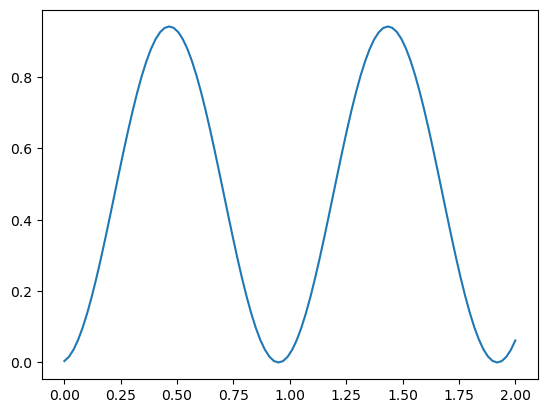

In [4]:
time = np.linspace(0, Rabi_plus_time*2, 100)
time_step = time[1]-time[0]
data = []

state_vec = np.zeros((np.size(basis), 1), dtype=np.complex128)
state_vec[0] = 1
for t in time:

    state_vec = time_evolve(time_step, Hplus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data.append(square[1])

plt.plot(time, data)
plt.show()

### MZI

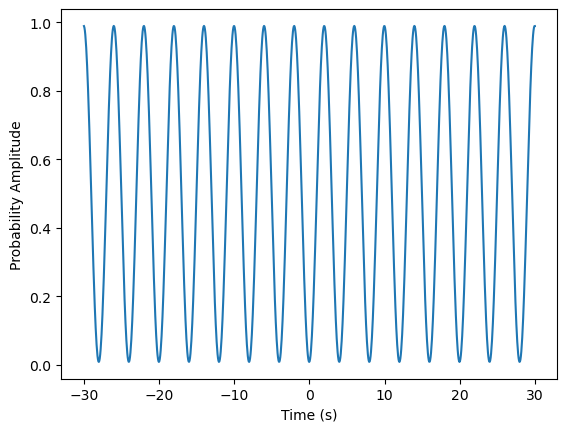

In [5]:
T = 100
free_time_range = np.linspace(-30, 30, 1000)
# time_step = time[1]-time[0]
# print(time_step)
# print(Rabi_plus_time)
data = []

for free_time in free_time_range:
    state_vec = np.zeros((np.size(basis), 1), dtype=np.complex128)
    state_vec[0] = 1

    state_vec = time_evolve(Rabi_plus_time/4, Hplus + H0) @ state_vec

    state_vec = time_evolve(T, H0) @ state_vec

    state_vec = time_evolve(Rabi_plus_time/2, Hplus + H0) @ state_vec
    
    state_vec = time_evolve(T + free_time, H0) @ state_vec
    
    state_vec = time_evolve(Rabi_plus_time/4, Hplus + H0) @ state_vec
    
    square = np.abs(state_vec)**2
    data.append(square[1])
  
# print(np.transpose(data))
plt.plot(free_time_range, data)
# plt.legend(basis,loc='upper left')
plt.xlabel('Time (s)')
plt.ylabel('Probability Amplitude')
plt.show()


### Alternating pulse sequence

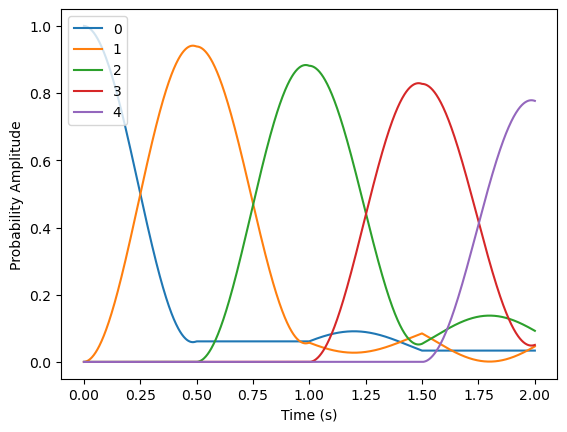

In [6]:
### ALTERNATING PULSE SEQUENCE
time = np.linspace(0, 2*Rabi_plus_time, 1000)
time_step = time[1]-time[0]
data = np.zeros((np.size(basis), np.size(time)))

state_vec = np.zeros((np.size(basis), 1), dtype=np.complex128)
state_vec[0] = 1
for i in range(int(np.size(time)/4)):
    state_vec = time_evolve(time_step, Hplus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data[:,i] = square[:,0]
    
for i in range(int(np.size(time)/4), int(np.size(time)/2)):
    state_vec = time_evolve(time_step, Hminus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data[:,i] = square[:,0]
    
for i in range(int(np.size(time)/2), int(np.size(time)*3/4)):
    state_vec = time_evolve(time_step, Hplus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data[:,i] = square[:,0]
    
for i in range(int(np.size(time)*3/4), int(np.size(time))):
    state_vec = time_evolve(time_step, Hminus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data[:,i] = square[:,0]
  
# print(np.transpose(data))
plt.plot(time,np.transpose(data))
plt.legend(basis,loc='upper left')
plt.xlabel('Time (s)')
plt.ylabel('Probability Amplitude')
plt.show()